In [1]:
# imports
import seaborn as sns
from matplotlib import pyplot as plt
import xarray
import h5py 
import pandas

from ulmo import io as ulmo_io
from ulmo.plotting import plotting

# imports
from importlib import reload

from ulmo import io as ulmo_io
import numpy as np
from ulmo import io as ulmo_io
from ulmo.viirs import io as viirs_io
from ulmo.viirs import extract as viirs_extract
from ulmo.plotting import plotting
from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting

import final_plots as fp
import spatial_plots as sp

sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()

In [2]:
viirs_tbl = ulmo_io.load_main_table('s3://viirs/Tables/VIIRS_all_99clear_std.parquet')

Read main table: s3://viirs/Tables/VIIRS_all_99clear_std.parquet


Min LL: -2526.65966796875
Max LL: 601.8599853515625
Mean LL: 42.49958419799805
RMS LL: 159.9447784423828


<Figure size 864x576 with 0 Axes>

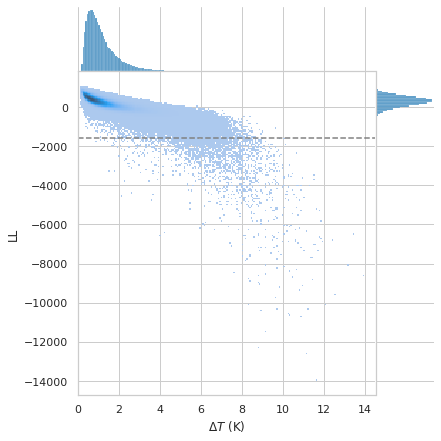

Wrote viirs_tbl


In [3]:
fp.fig_LL_vs_DT(ptype='std', outfile='viirs_tbl', evals_tbl=viirs_tbl)

/home/jovyan/final_plots.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.2,h_pad=0.2,w_pad=0.1)


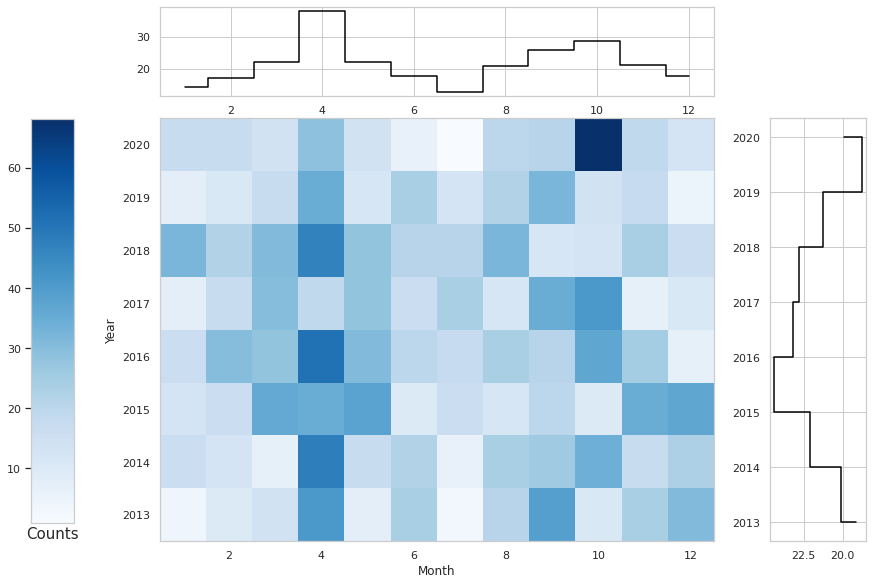

In [11]:
fp.fig_year_month(outfile='viirs_tbl', ptype='std', evals_tbl=viirs_tbl)

In [ ]:
## change above to just outliers :)

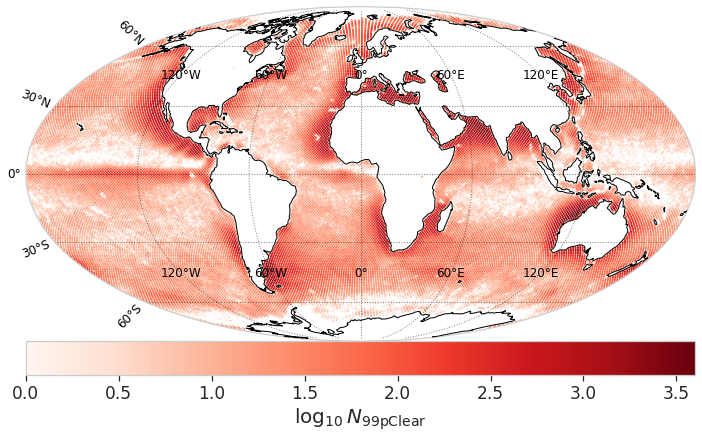

<GeoAxesSubplot:>

In [10]:
ulmo_figs.show_spatial(viirs_tbl, lbl='99pClear')

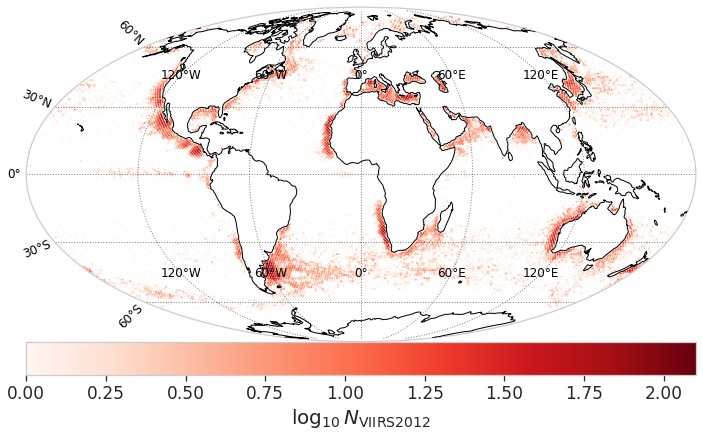

In [15]:
dt = ((viirs_tbl.T90-viirs_tbl.T10) > 2) & ((viirs_tbl.T90-viirs_tbl.T10) < 2.1)

_ = ulmo_figs.show_spatial(viirs_tbl[dt], lbl='VIIRS 2012')

In [11]:
import cartopy.crs as ccrs

import pandas

def show_spatial_LL_diff(main_tbl:pandas.DataFrame,
                 nside=64, use_log=True, 
                 use_mask=True,
                 lbl1='Lower10', lbl2='Higer10', lbl3='Both', figsize=(24,16), 
                 color1='Blues', color2='Oranges', color3='Greys', show=True):
    """Generate a global map of the location of the input
    cutouts
    Args:
        sub_tbl1: table of cutouts
        sub_tbl2: table of cutouts to compare to tbl1
        nside (int, optional): [description]. Defaults to 64.
        use_log (bool, optional): [description]. Defaults to True.
        use_mask (bool, optional): [description]. Defaults to True.
        lbl ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (12,8).
        color (str, optional): [description]. Defaults to 'Oranges'.
        show (bool, optional): If True, show on the screen.  Defaults to True
    Returns:
        matplotlib.Axis: axis holding the plot
    """
    N = int(np.round(0.1*len(main_tbl)))
    sub_tbl1 = main_tbl[:N]
    sub_tbl2 = main_tbl[-N:]
    
    # Healpix me
    hp_events1, hp_lons1, hp_lats1 = image_utils.evals_to_healpix(
        sub_tbl1, nside, log=use_log, mask=use_mask)
    
    hp_events2, hp_lons2, hp_lats2 = image_utils.evals_to_healpix(
        sub_tbl2, nside, log=use_log, mask=use_mask)
    
    # Figure
    
    fig = plt.figure(figsize=figsize)
    plt.clf()

    tformM = ccrs.Mollweide()
    tformP = ccrs.PlateCarree()

    ax = plt.axes(projection=tformM)

    cm1 = plt.get_cmap(color1)
    cm2 = plt.get_cmap(color2)
    cm3 = plt.get_cmap(color3)
    
    # Cut
    good1 = np.invert(hp_events1.mask)
    img1 = plt.scatter(x=hp_lons1[good1],
        y=hp_lats1[good1],
        c=hp_events1[good1], 
        cmap=cm1,
        s=1,
        transform=tformP)
    
    good2 = np.invert(hp_events2.mask)
    img2 = plt.scatter(x=hp_lons2[good2],
        y=hp_lats2[good2],
        c=hp_events2[good2], 
        cmap=cm2,
        s=1,
        transform=tformP)
    
    both = np.invert((hp_events2.mask==False) & (hp_events1.mask ==False))
    img3 = plt.scatter(x=hp_lons2[both],
        y=hp_lats2[both],
        c=hp_events2[both],
        cmap=cm3,
        s=1,
        transform=tformP) 
    

    # Colorbar
    cb1 = plt.colorbar(img1, orientation='vertical', location = 'left',shrink=0.45,pad=0.03)
    cb2 = plt.colorbar(img2, orientation='vertical', location = 'right',shrink=0.45,pad=0.03)
    cb3 = plt.colorbar(img3, orientation='horizontal', location = 'bottom',pad=0.01)
    
    if lbl1 is not None:
        clbl1=r'$\log_{10} \, N_{\rm '+'{}'.format(lbl1)+'}$'
        cb1.set_label(clbl1, fontsize=20.)
    cb1.ax.tick_params(labelsize=17)
    
    if lbl2 is not None:
        clbl2=r'$\log_{10} \, N_{\rm '+'{}'.format(lbl2)+'}$'
        cb2.set_label(clbl2, fontsize=20.)
    cb2.ax.tick_params(labelsize=17)
    
    if lbl3 is not None:
        clbl3=r'$\log_{10} \, N_{\rm '+'{}'.format(lbl3)+'}$'
        cb3.set_label(clbl3, fontsize=20.)
    cb3.ax.tick_params(labelsize=17)
    

    # Coast lines
    ax.coastlines(zorder=10)
    ax.set_global()

    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
        color='black', alpha=0.5, linestyle=':', draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right=False
    gl.xlines = True
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'black'}# 'weight': 'bold'}
    gl.ylabel_style = {'color': 'black'}# 'weight': 'bold'}


    # Layout and save
    plt.show
    #plt.savefig('month_by_year_of_'+ str(outfile), dpi=600)

    return ax

<GeoAxesSubplot:>

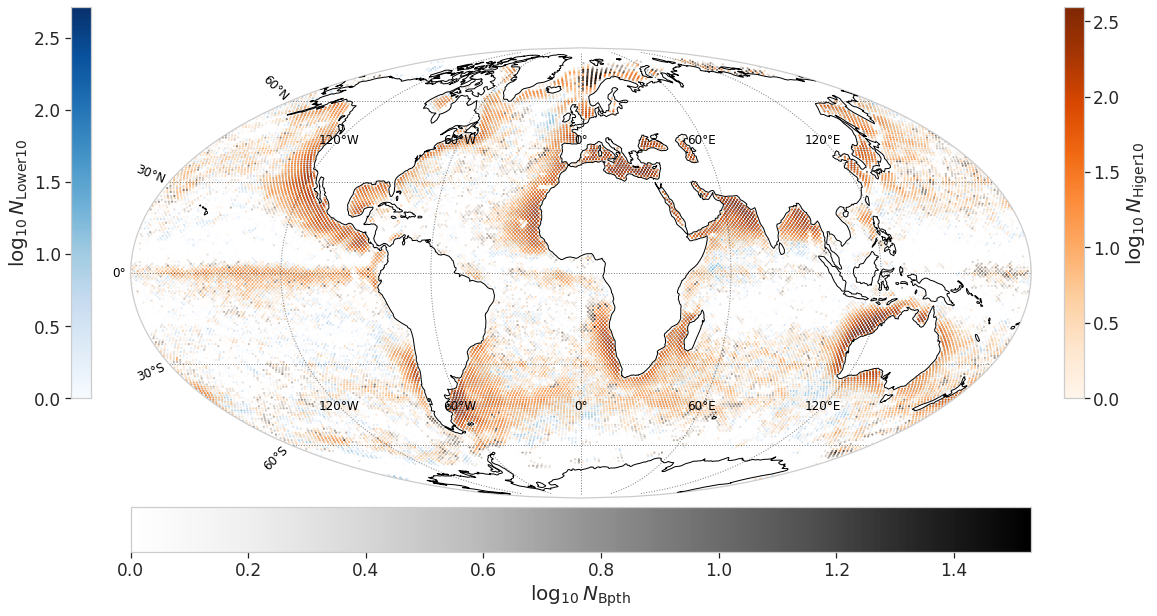

In [154]:
dt = ((viirs_tbl.T90-viirs_tbl.T10) > 0.25) & ((viirs_tbl.T90-viirs_tbl.T10) < 0.45)

show_spatial_LL_diff(viirs_tbl)

In [18]:
modis_tbl = ulmo_io.load_main_table('s3://modis-l2/Tables/MODIS_L2_std.parquet')

Read main table: s3://modis-l2/Tables/MODIS_L2_std.parquet


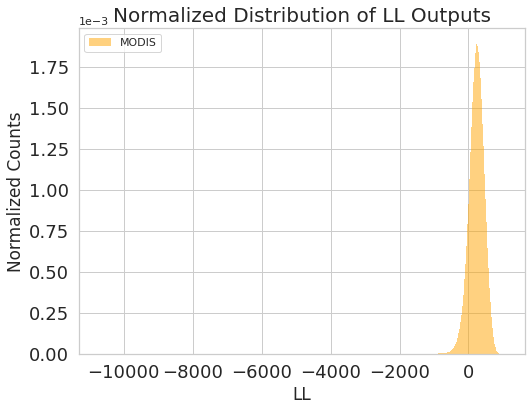

In [7]:
fig = plt.figure(figsize=(8,6))

#ax = sns.histplot(data=viirs_tbl, x='LL',alpha=0.75, stat='density',label = 'VIIRS')
ax = sns.histplot(data=modis_tbl, x='LL',color='orange',alpha=0.5, stat='density',label = 'MODIS')
plotting.set_fontsize(ax, 17.)
#plt.xlim(-1500,1500)
plt.title('Normalized Distribution of LL Outputs',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.ylabel('Normalized Counts')
plt.savefig('test_mod.png',dpi=1200)
plt.show()

In [25]:
clear99 = (viirs_tbl.clear_fraction > 0.01)
clear99_m = (modis_tbl.clear_fraction > 0.01)

In [113]:
modis_tbl.datetime[6804000-258354:6804000-220000+1]

6545646   2011-07-19 16:05:00
6545647   2011-06-23 20:35:00
6545648   2011-10-23 04:40:00
6545649   2011-11-02 08:25:00
6545650   2012-04-07 22:50:00
                  ...        
6583996   2012-08-28 07:20:00
6583997   2012-12-25 23:55:00
6583998   2012-06-02 23:45:00
6583999   2012-03-24 10:45:00
6584000   2012-04-17 23:15:00
Name: datetime, Length: 38355, dtype: datetime64[ns]

In [ ]:

fig = plt.figure(figsize=(8,6))

ax = sns.histplot(data=viirs_tbl, x='LL',alpha=0.75, stat='density',label = 'VIIRS')
ax = sns.histplot(data=modis_tbl[clear99_m][6545650:], x='LL',color='orange',alpha=0.5, stat='density',label = 'MODIS')
plotting.set_fontsize(ax, 17.)
plt.xlim(-1500,1500)
plt.title('Normalized Distribution of LL Outputs',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.ylabel('Normalized Counts')
plt.savefig('test.png', dpi=600)
plt.show()

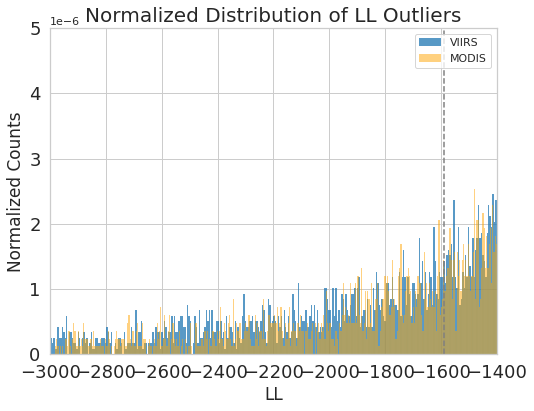

In [31]:
#add vertical line at -1590 for outliers
fig = plt.figure(figsize=(8,6))

ax = sns.histplot(data=viirs_tbl, x='LL',alpha=0.75, stat='density',label = 'VIIRS')
ax = sns.histplot(data=modis_tbl[clear99_m][6545650:], x='LL',color='orange',alpha=0.5, stat='density',label = 'MODIS')
plotting.set_fontsize(ax, 17.)
plt.xlim(-3000,-1400)
plt.title('Normalized Distribution of LL Outliers',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.vlines(-1590,0,0.00005,'grey',linestyle='--')
plt.ylim(0,0.000005)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.ylabel('Normalized Counts')
plt.savefig('testzoom.png', dpi=600)
plt.show()

In [13]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def show_spatial(main_tbl:pandas.DataFrame, 
                 nside=64, use_log=True, 
                 use_mask=True, tricontour=False,
                 lbl=None, figsize=(12,8), 
                 color='Reds', show=True):
    """Generate a global map of the location of the input
    cutouts

    Args:
        main_tbl (pandas.DataFrame): table of cutouts
        nside (int, optional): [description]. Defaults to 64.
        use_log (bool, optional): [description]. Defaults to True.
        use_mask (bool, optional): [description]. Defaults to True.
        tricontour (bool, optional): [description]. Defaults to False.
        lbl ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (12,8).
        color (str, optional): [description]. Defaults to 'Reds'.
        show (bool, optional): If True, show on the screen.  Defaults to True

    Returns:
        matplotlib.Axis: axis holding the plot
    """
    # Healpix me
    hp_events, hp_lons, hp_lats = image_utils.evals_to_healpix(
        main_tbl, nside, log=use_log, mask=use_mask)
    
    # Figure
    
    fig = plt.figure(figsize=figsize)
    plt.clf()

    tformM = ccrs.Mollweide()
    tformP = ccrs.PlateCarree()

    ax = plt.axes(projection=tformM)

    if tricontour:
        cm = plt.get_cmap(color)
        img = ax.tricontourf(hp_lons, hp_lats, hp_events, transform=tformM,
                         levels=20, cmap=cm)#, zorder=10)
    else:
        cm = plt.get_cmap(color)
        # Cut
        good = np.invert(hp_events.mask)
        img = plt.scatter(x=hp_lons[good],
            y=hp_lats[good],
            c=hp_events[good],
            cmap=cm,
            s=1,
            transform=tformP)

    # Colorbar
    cb = plt.colorbar(img, orientation='horizontal', pad=0.)
    if lbl is not None:
        clbl=r'$\log_{10} \, N_{\rm '+'{}'.format(lbl)+'}$'
        cb.set_label(clbl, fontsize=20.)
    cb.ax.tick_params(labelsize=17)

    # Coast lines
    if not tricontour:
        ax.coastlines(zorder=10)
        ax.set_global()
    
        gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
            color='black', alpha=0.5, linestyle=':', draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_left = True
        gl.ylabels_right=False
        gl.xlines = True
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'color': 'black'}# 'weight': 'bold'}
        gl.ylabel_style = {'color': 'black'}# 'weight': 'bold'}
        #gl.xlocator = mticker.FixedLocator([-180., -160, -140, -120, -60, -20.])
        #gl.xlocator = mticker.FixedLocator([-240., -180., -120, -65, -60, -55, 0, 60, 120.])
        #gl.ylocator = mticker.FixedLocator([0., 15., 30., 45, 60.])


    # Layout and save
    plt.savefig('dt_viirs_99',dpi=600)
    plt.show()
        

    return ax

In [12]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

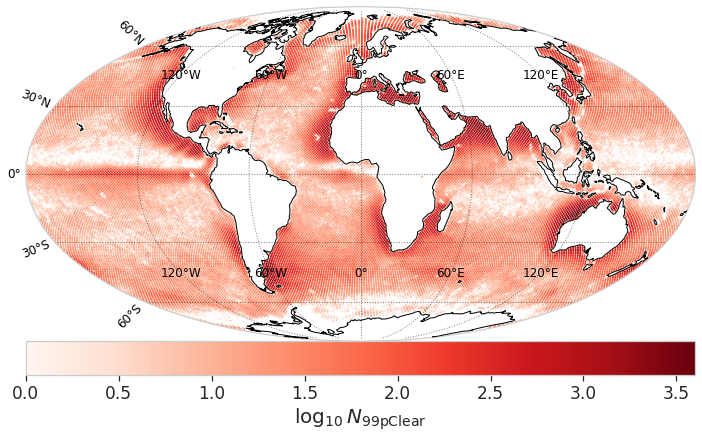

<GeoAxesSubplot:>

In [19]:
show_spatial(viirs_tbl, lbl='99pClear')

In [25]:
test = (viirs_tbl.LL < -1590)

len(viirs_tbl[test])

2289

In [7]:
len(viirs_tbl)

2291590

In [9]:
def plt_ex(extr):
    fig = plt.figure(figsize=(6,12))
    img = plt.imshow(extr, origin='lower', cmap=cm)#, vmin=-3)
    cb = plt.colorbar(img, fraction=0.020, pad=0.04)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

In [8]:
viirs_cutouts = ('s3://viirs/PreProc/VIIRS_2013_95clear_192x192_preproc_viirs_std.h5')
modis_cutouts = ('s3://modis-l2/PreProc/MODIS_R2019_2013_95clear_128x128_preproc_std.h5')

In [17]:
with ulmo_io.open(viirs_cutouts, 'rb') as f:
    viirs_cut_ex_hf = h5py.File(f, 'r')
    
with ulmo_io.open(modis_cutouts, 'rb') as f:
    modis_cut_ex_hf = h5py.File(f, 'r')

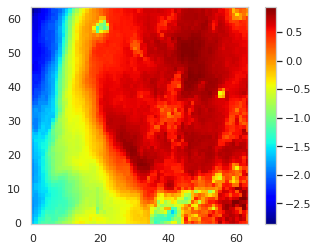

In [19]:
viirs = ((viirs_cut_ex_hf['valid'][382744, 0, ...]))
plt.imshow(viirs,cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.grid(False)

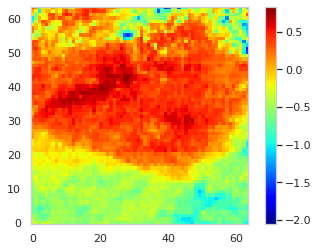

In [20]:
modis = ((modis_cut_ex_hf['valid'][382744, 0, ...]))
plt.imshow(modis,cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.grid(False)

In [14]:
viirs_file = 's3://viirs/Extractions/VIIRS_2013_95clear_192x192_inpaint.h5'

with ulmo_io.open(viirs_file, 'rb') as f:
    viirs_ex_hf = h5py.File(f, 'r')
    
modis_file = 's3://modis-l2/Extractions/MODIS_R2019_2011_day_95clear_128x128_inpaint.h5'

with ulmo_io.open(modis_file, 'rb') as f:
    modis_ex_hf = h5py.File(f, 'r')

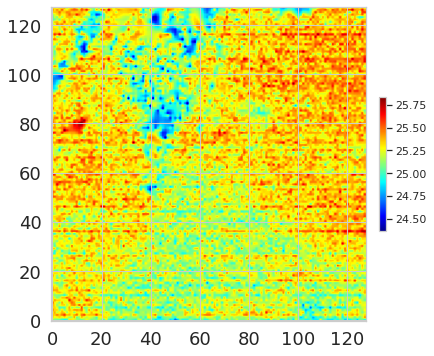

In [16]:
mod = modis_ex_hf['fields'][382744,...]
plt_ex(mod)

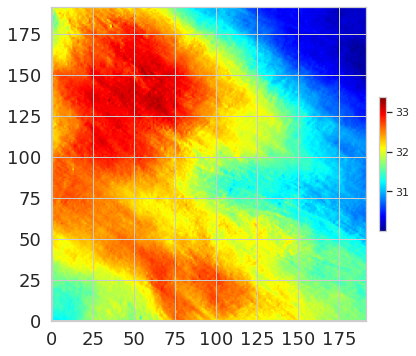

In [15]:
vir = viirs_ex_hf['fields'][382744,...]
plt_ex(vir)

In [3]:
low = ((viirs_tbl.T90 - viirs_tbl.T10 ) > 1) & ((viirs_tbl.T90 - viirs_tbl.T10 ) < 1.5) & ((viirs_tbl.LL)>0) & ((viirs_tbl.LL)<200)
high = ((viirs_tbl.T90 - viirs_tbl.T10 ) > 1) & ((viirs_tbl.T90 - viirs_tbl.T10 ) < 1.5) & ((viirs_tbl.LL)>400) & ((viirs_tbl.LL)<600)

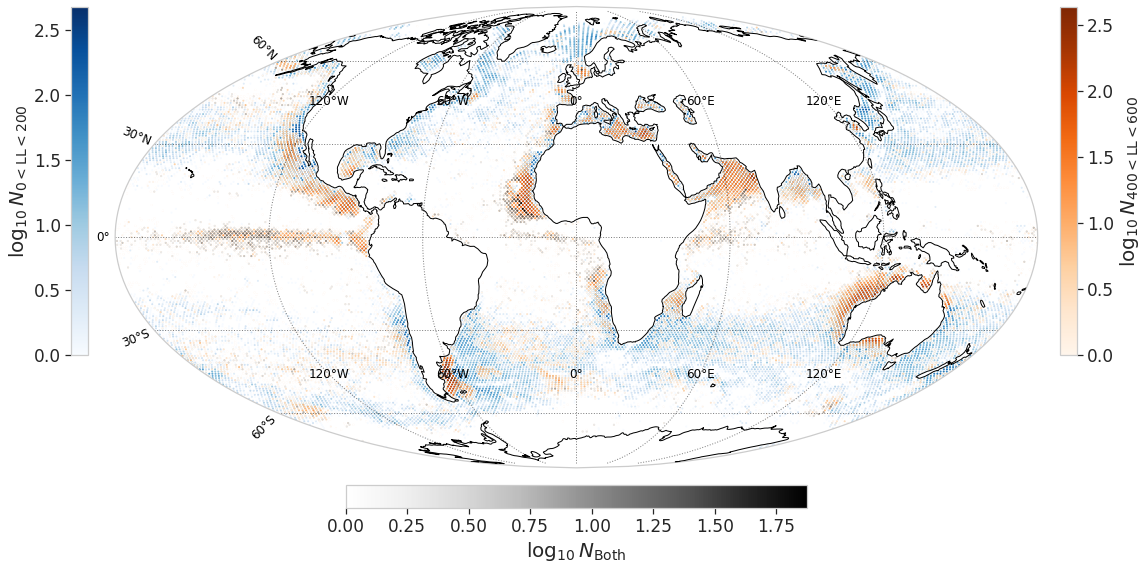

<GeoAxesSubplot:>

In [5]:
sp.show_spatial_diff(viirs_tbl[low],viirs_tbl[high],lbl1='0<LL<200',lbl2='400<LL<600',lbl3='Both')

In [ ]:
plt.hist(viirs_tbl[low].LL,alpha=0.75)
plt.hist(viirs_tbl[high].LL,alpha=0.75)
plt.show()

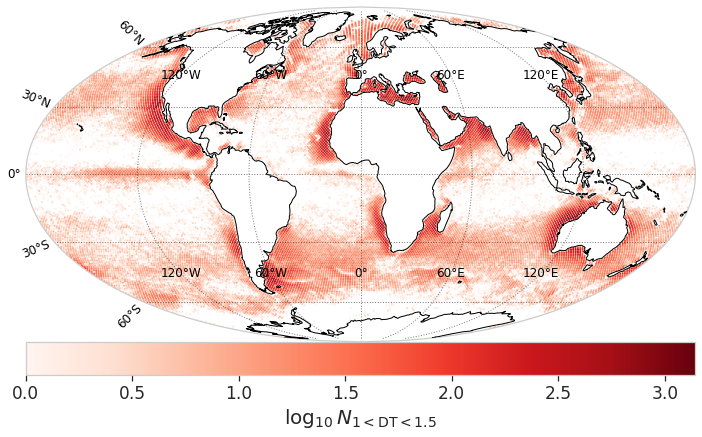

<GeoAxesSubplot:>

In [16]:
dt = ((viirs_tbl.T90 - viirs_tbl.T10 ) > 1) & ((viirs_tbl.T90 - viirs_tbl.T10 ) < 1.5)
show_spatial(viirs_tbl[dt], lbl='1<DT<1.5')

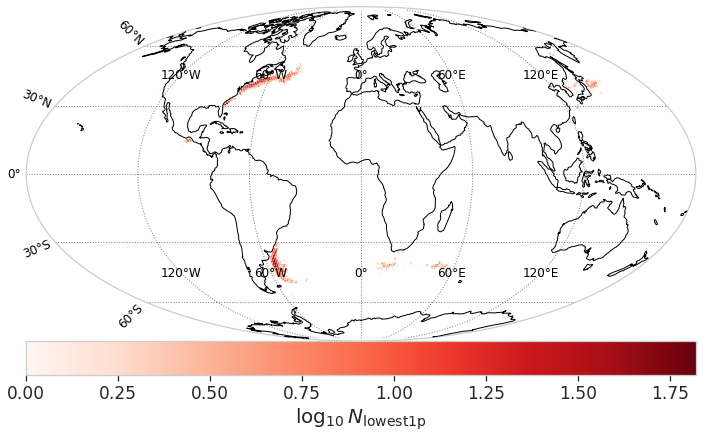

<GeoAxesSubplot:>

In [17]:
lowlow = ((viirs_tbl.LL ) < -1590) 
show_spatial(viirs_tbl[lowlow], lbl='lowest1p')

In [19]:
0.001*len(modis_tbl)

12493.761

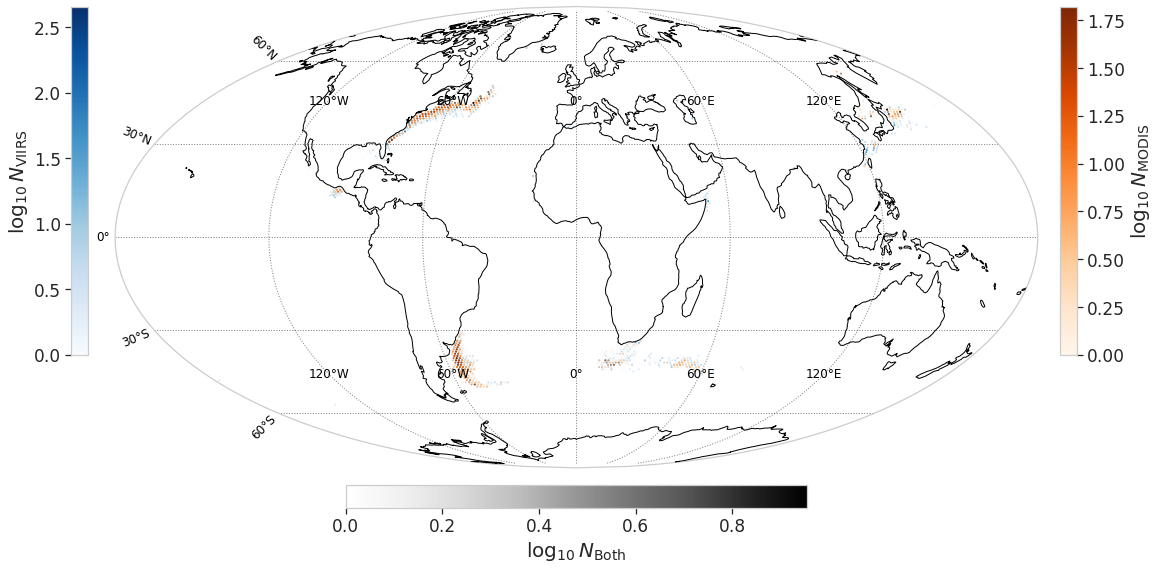

<GeoAxesSubplot:>

In [23]:
lowlow = ((viirs_tbl.LL ) < -1590) 
low_m = ((modis_tbl.LL ) < -1390) 
#show_spatial(viirs_tbl[lowlow], lbl='lowest1p')

sp.show_spatial_diff(modis_tbl[low_m],viirs_tbl[lowlow],lbl1='VIIRS',lbl2='MODIS',lbl3='Both')